<a href="https://colab.research.google.com/github/raf-esc/alura_challenge_data_science_2/blob/main/semanas_3_e_4/alura_challenge_data_science_2_semanas_3_e_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alura - Challenge Data Science 2 - Semanas 3 e 4

## 1ª Tarefa - Preparar o Ambiente e Carregar a Base de Dados

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=48c221add4d9c4ff84cd962a88f57df083968678184b69e2ff056724e006a3f8
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import vector_to_array
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean

In [3]:
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [4]:
spark

In [5]:
# from google.colab import drive
# drive.mount('content/drive')

In [6]:
dados = spark.read.parquet('/content/drive/MyDrive/Alura/Challenge - Data Science 2/parquet_para_recomendacao')

In [7]:
dados.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|        Santo Cristo|     100.0| 100.0

In [8]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: double (nullable = true)
 |-- vaga: double (nullable = true)
 |-- bairro: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zona Sul: integer (nullable = true)
 |-- Academia: integer (nullable = true)
 |-- Animais permitidos: integer (nullable = true)
 |-- Churrasqueira: integer (nullable = true)
 |-- Condomínio fechado: integer (nullable = true)
 |-- Elevador: integer (nullable = true)
 |-- Piscina: integer (nullable = true)
 |-- Playground: integer (nullable = true)
 |-- Portaria 24h: integer (nullable = true)
 |-- Portão eletrônico: integer (nullable 

## 2ª Tarefa - Preparando os dados

Vamos aplicar as transformações necessárias para utilizar os dados no nosso modelos de clustering.

In [9]:
dados.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'bairro',
 'condominio',
 'iptu',
 'valor',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas']

In [10]:
X = dados.columns
X.remove('bairro')
X.remove('id')
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas']

In [11]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')
dados_vetorizados = assembler.transform(dados)

In [12]:
dados_vetorizados.select('id', 'features').show()

+--------------------+--------------------+
|                  id|            features|
+--------------------+--------------------+
|00002dd9-cc74-480...|[2.0,35.0,1.0,1.0...|
|0009ca94-2b37-438...|(23,[0,1,2,3,5,6,...|
|000e3d28-e3e5-411...|(23,[1,2,3,6,7,8,...|
|000fb707-6cad-496...|(23,[1,2,3,5,6,7,...|
|001b6db0-e88d-4eb...|(23,[1,2,3,4,5,6,...|
|002db67e-52cc-480...|[0.0,200.0,6.0,4....|
|002dc4e0-f1a5-4ad...|(23,[1,2,3,6,8,10...|
|0030dd84-f657-41f...|(23,[0,1,2,3,4,5,...|
|003213bb-ec21-4ad...|(23,[1,2,3,4,5,8,...|
|0032884c-aa5f-455...|[0.0,41.0,1.0,1.0...|
|00348cd1-923a-4db...|[5.0,78.0,1.0,2.0...|
|0034df72-124a-438...|(23,[1,2,3,4,5,6,...|
|0036114a-4a0f-492...|(23,[1,2,3,4,5,6,...|
|00370d62-f774-405...|(23,[1,2,3,4,5,6,...|
|00396d9d-2d0e-4b5...|[9.0,120.0,2.0,2....|
|003cb63c-a666-458...|[20.0,341.0,2.0,3...|
|0040f5a7-6c6a-40e...|[0.0,194.0,5.0,4....|
|00529a9d-d876-4dc...|(23,[1,2,3,8,10,2...|
|00584813-33b4-477...|(23,[0,1,2,3,8,10...|
|005b5441-16b2-483...|(23,[0,1,2

## 3ª Tarefa - Padronizando os dados

É importante padronizarmos os dados para conseguirmos utilizar o PCA.

In [13]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
scaler_model = scaler.fit(dados_vetorizados)
dados_padronizados = scaler_model.transform(dados_vetorizados)

In [14]:
dados_padronizados.select('id', 'scaled_features').show()

+--------------------+--------------------+
|                  id|     scaled_features|
+--------------------+--------------------+
|00002dd9-cc74-480...|[0.13607726247524...|
|0009ca94-2b37-438...|(23,[0,1,2,3,5,6,...|
|000e3d28-e3e5-411...|(23,[1,2,3,6,7,8,...|
|000fb707-6cad-496...|(23,[1,2,3,5,6,7,...|
|001b6db0-e88d-4eb...|(23,[1,2,3,4,5,6,...|
|002db67e-52cc-480...|[0.0,2.2447697820...|
|002dc4e0-f1a5-4ad...|(23,[1,2,3,6,8,10...|
|0030dd84-f657-41f...|(23,[0,1,2,3,4,5,...|
|003213bb-ec21-4ad...|(23,[1,2,3,4,5,8,...|
|0032884c-aa5f-455...|[0.0,0.4601778053...|
|00348cd1-923a-4db...|[0.34019315618810...|
|0034df72-124a-438...|(23,[1,2,3,4,5,6,...|
|0036114a-4a0f-492...|(23,[1,2,3,4,5,6,...|
|00370d62-f774-405...|(23,[1,2,3,4,5,6,...|
|00396d9d-2d0e-4b5...|[0.61234768113858...|
|003cb63c-a666-458...|[1.36077262475241...|
|0040f5a7-6c6a-40e...|[0.0,2.1774266885...|
|00529a9d-d876-4dc...|(23,[1,2,3,8,10,2...|
|00584813-33b4-477...|(23,[0,1,2,3,8,10...|
|005b5441-16b2-483...|(23,[0,1,2

## 4ª Tarefa - Redução de dimensionalidade

Para conseguirmos criar nosso modelo de recomendação, precisamos reduzir a dimensão dos nossos dados. Para fazermos isso, podemos utilizar a técnica chamada PCA.

Aplicando essa técnica, teremos um novo conjunto de dados onde as colunas serão uma combinação linear das colunas originais.

In [15]:
k = len(X)

In [16]:
pca_teste = PCA(k = k, inputCol = 'scaled_features', outputCol = 'pca_features')
model_pca_teste = pca_teste.fit(dados_padronizados)
dados_pca_para_teste = model_pca_teste.transform(dados_padronizados)

In [17]:
model_pca_teste.explainedVariance * 100

DenseVector([26.5457, 17.2067, 9.1274, 5.4374, 5.223, 4.662, 4.4266, 4.1602, 3.4682, 2.7227, 2.4395, 2.0104, 1.921, 1.7612, 1.5507, 1.3895, 1.2007, 1.1335, 1.011, 0.923, 0.8898, 0.7896, 0.0])

In [18]:
lista_de_valores = [sum(model_pca_teste.explainedVariance[0:i]) for i in range(k)]
k_minimo = sum(np.array(lista_de_valores) <= 0.8)
k_minimo

9

In [19]:
sum(model_pca_teste.explainedVariance[0:k_minimo]) * 100

80.2573009561341

In [20]:
pca_80 = PCA(k = k_minimo, inputCol = 'scaled_features', outputCol = 'pca_features')
model_80 = pca_80.fit(dados_padronizados)
dados_pca_80 = model_80.transform(dados_padronizados)

In [21]:
dados_pca_80.select('id', 'pca_features').show()

+--------------------+--------------------+
|                  id|        pca_features|
+--------------------+--------------------+
|00002dd9-cc74-480...|[-6.1651250495338...|
|0009ca94-2b37-438...|[-3.2529111812184...|
|000e3d28-e3e5-411...|[-1.0611769329629...|
|000fb707-6cad-496...|[-1.9958119007838...|
|001b6db0-e88d-4eb...|[-0.4181406070145...|
|002db67e-52cc-480...|[-6.9015238649802...|
|002dc4e0-f1a5-4ad...|[-0.7164221492881...|
|0030dd84-f657-41f...|[-1.4856960209870...|
|003213bb-ec21-4ad...|[-6.0456283208921...|
|0032884c-aa5f-455...|[-6.1992405713781...|
|00348cd1-923a-4db...|[-6.8846811115737...|
|0034df72-124a-438...|[-4.6134703872769...|
|0036114a-4a0f-492...|[-4.4763270618055...|
|00370d62-f774-405...|[-0.9935595784851...|
|00396d9d-2d0e-4b5...|[-3.1645192533431...|
|003cb63c-a666-458...|[-3.5460599405485...|
|0040f5a7-6c6a-40e...|[-7.5070643480675...|
|00529a9d-d876-4dc...|[-0.6502007974669...|
|00584813-33b4-477...|[-0.1271532177362...|
|005b5441-16b2-483...|[-2.849363

## 5ª Tarefa - Criando nossos clusters

In [22]:
seed = 1998

10 clusters

In [23]:
kmeans = KMeans(featuresCol = 'pca_features', predictionCol = 'cluster_pca')\
.setK(10).setSeed(seed)

In [24]:
model_kmeans = kmeans.fit(dados_pca_80)

In [25]:
previsoes_kmeans = model_kmeans.transform(dados_pca_80)

In [26]:
previsoes_kmeans.select('id', 'pca_features', 'cluster_pca').show()

+--------------------+--------------------+-----------+
|                  id|        pca_features|cluster_pca|
+--------------------+--------------------+-----------+
|00002dd9-cc74-480...|[-6.1651250495338...|          6|
|0009ca94-2b37-438...|[-3.2529111812184...|          3|
|000e3d28-e3e5-411...|[-1.0611769329629...|          8|
|000fb707-6cad-496...|[-1.9958119007838...|          1|
|001b6db0-e88d-4eb...|[-0.4181406070145...|          3|
|002db67e-52cc-480...|[-6.9015238649802...|          0|
|002dc4e0-f1a5-4ad...|[-0.7164221492881...|          3|
|0030dd84-f657-41f...|[-1.4856960209870...|          3|
|003213bb-ec21-4ad...|[-6.0456283208921...|          0|
|0032884c-aa5f-455...|[-6.1992405713781...|          5|
|00348cd1-923a-4db...|[-6.8846811115737...|          5|
|0034df72-124a-438...|[-4.6134703872769...|          1|
|0036114a-4a0f-492...|[-4.4763270618055...|          1|
|00370d62-f774-405...|[-0.9935595784851...|          8|
|00396d9d-2d0e-4b5...|[-3.1645192533431...|     

In [27]:
df_previsoes_x_y = previsoes_kmeans\
.withColumn('x', vector_to_array('pca_features')[0])\
.withColumn('y', vector_to_array('pca_features')[1])\
.select('x', 'y', 'cluster_pca', 'id')

In [28]:
df_previsoes_x_y.show()

+--------------------+-------------------+-----------+--------------------+
|                   x|                  y|cluster_pca|                  id|
+--------------------+-------------------+-----------+--------------------+
|  -6.165125049533806|  1.338098526940569|          6|00002dd9-cc74-480...|
| -3.2529111812184834|-1.1179591836228846|          3|0009ca94-2b37-438...|
| -1.0611769329629526|-1.6685040058694276|          8|000e3d28-e3e5-411...|
| -1.9958119007838695|-1.7655796610847834|          1|000fb707-6cad-496...|
| -0.4181406070145915|-2.1310407911416904|          3|001b6db0-e88d-4eb...|
|  -6.901523864980264| -6.262240376053033|          0|002db67e-52cc-480...|
| -0.7164221492881179|-1.4040232409557407|          3|002dc4e0-f1a5-4ad...|
| -1.4856960209870202|-1.7808507073415776|          3|0030dd84-f657-41f...|
|  -6.045628320892147| -7.824880763294737|          0|003213bb-ec21-4ad...|
|  -6.199240571378109|0.31242092235493363|          5|0032884c-aa5f-455...|
|  -6.884681

In [29]:
x = list(df_previsoes_x_y.toPandas()['x'])
y = list(df_previsoes_x_y.toPandas()['y'])
clusters = list(df_previsoes_x_y.toPandas()['cluster_pca'])

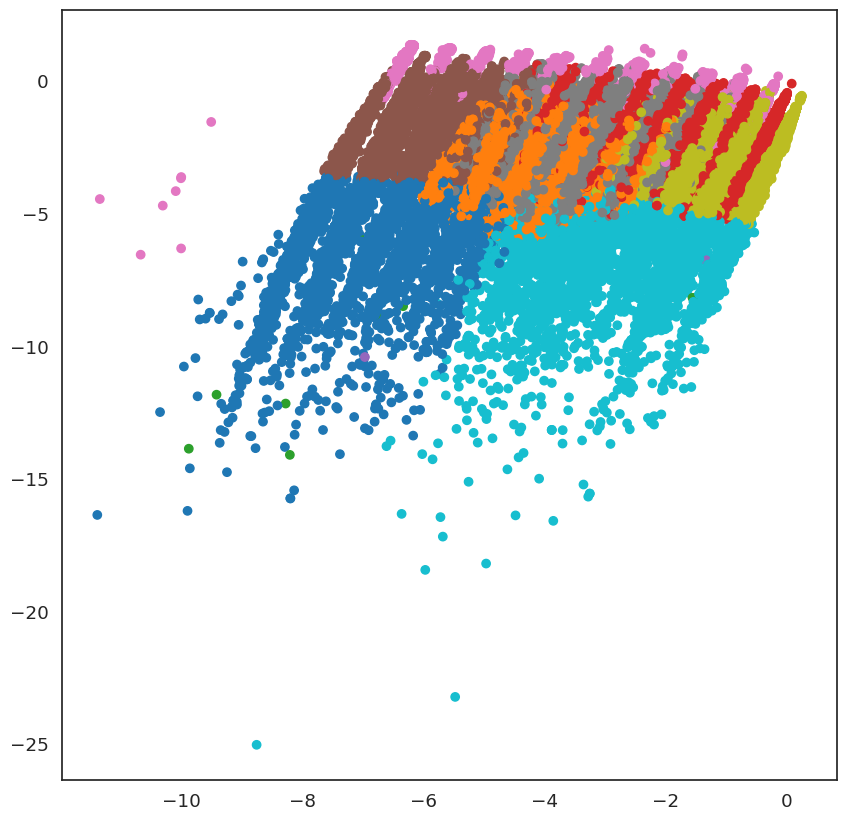

In [30]:
sns.set(style = 'white', rc = {'figure.figsize': (10, 10)}, font_scale = 1.2)

plt.scatter(x = x, y = y, c = clusters, cmap = 'tab10')
plt.show()

8 clusters

In [31]:
kmeans = KMeans(featuresCol = 'pca_features', predictionCol = 'cluster_pca')\
.setK(8).setSeed(seed)

In [32]:
model_kmeans = kmeans.fit(dados_pca_80)

In [33]:
previsoes_kmeans = model_kmeans.transform(dados_pca_80)

In [34]:
previsoes_kmeans.select('id', 'pca_features', 'cluster_pca').show()

+--------------------+--------------------+-----------+
|                  id|        pca_features|cluster_pca|
+--------------------+--------------------+-----------+
|00002dd9-cc74-480...|[-6.1651250495338...|          1|
|0009ca94-2b37-438...|[-3.2529111812184...|          5|
|000e3d28-e3e5-411...|[-1.0611769329629...|          7|
|000fb707-6cad-496...|[-1.9958119007838...|          7|
|001b6db0-e88d-4eb...|[-0.4181406070145...|          5|
|002db67e-52cc-480...|[-6.9015238649802...|          4|
|002dc4e0-f1a5-4ad...|[-0.7164221492881...|          5|
|0030dd84-f657-41f...|[-1.4856960209870...|          5|
|003213bb-ec21-4ad...|[-6.0456283208921...|          4|
|0032884c-aa5f-455...|[-6.1992405713781...|          0|
|00348cd1-923a-4db...|[-6.8846811115737...|          0|
|0034df72-124a-438...|[-4.6134703872769...|          0|
|0036114a-4a0f-492...|[-4.4763270618055...|          0|
|00370d62-f774-405...|[-0.9935595784851...|          7|
|00396d9d-2d0e-4b5...|[-3.1645192533431...|     

In [35]:
df_previsoes_x_y = previsoes_kmeans\
.withColumn('x', vector_to_array('pca_features')[0])\
.withColumn('y', vector_to_array('pca_features')[1])\
.select('x', 'y', 'cluster_pca', 'id')

In [36]:
df_previsoes_x_y.show()

+--------------------+-------------------+-----------+--------------------+
|                   x|                  y|cluster_pca|                  id|
+--------------------+-------------------+-----------+--------------------+
|  -6.165125049533806|  1.338098526940569|          1|00002dd9-cc74-480...|
| -3.2529111812184834|-1.1179591836228846|          5|0009ca94-2b37-438...|
| -1.0611769329629526|-1.6685040058694276|          7|000e3d28-e3e5-411...|
| -1.9958119007838695|-1.7655796610847834|          7|000fb707-6cad-496...|
| -0.4181406070145915|-2.1310407911416904|          5|001b6db0-e88d-4eb...|
|  -6.901523864980264| -6.262240376053033|          4|002db67e-52cc-480...|
| -0.7164221492881179|-1.4040232409557407|          5|002dc4e0-f1a5-4ad...|
| -1.4856960209870202|-1.7808507073415776|          5|0030dd84-f657-41f...|
|  -6.045628320892147| -7.824880763294737|          4|003213bb-ec21-4ad...|
|  -6.199240571378109|0.31242092235493363|          0|0032884c-aa5f-455...|
|  -6.884681

In [37]:
x = list(df_previsoes_x_y.toPandas()['x'])
y = list(df_previsoes_x_y.toPandas()['y'])
clusters = list(df_previsoes_x_y.toPandas()['cluster_pca'])

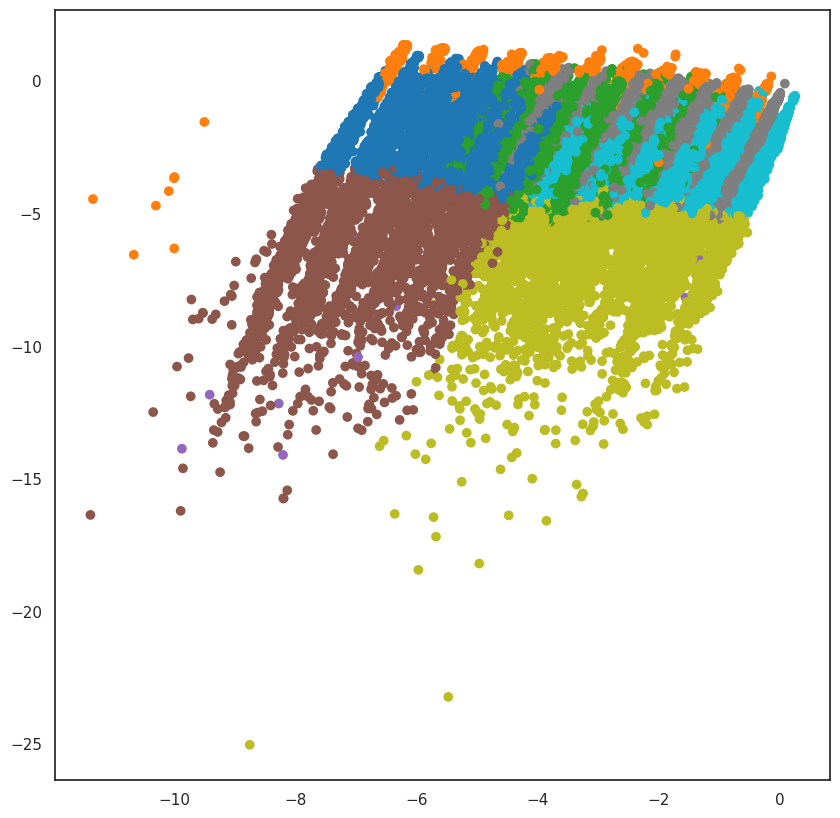

In [38]:
sns.set(style = 'white', rc = {'figure.figsize': (10, 10)})

plt.scatter(x = x, y = y, c = clusters, cmap = 'tab10')
plt.show()

## 6ª Tarefa - Filtrar imóveis do mesmo cluster

Com os clusters prontos, podemos criar um filtro para extrair as informações de ID de um imóvel e verificar quais imóveis pertencem ao mesmo cluster.

In [39]:
id = '0030dd84-f657-41f3-8b86-0f2a72e0fb55'

In [40]:
cluster_do_id = previsoes_kmeans.filter(previsoes_kmeans['id'] == id).select('cluster_pca').collect()[0][0]

In [41]:
ids_imoveis_mesmo_cluster = previsoes_kmeans.filter(previsoes_kmeans['cluster_pca'] == cluster_do_id)

In [42]:
ids_imoveis_mesmo_cluster.select('id', 'cluster_pca').show()

+--------------------+-----------+
|                  id|cluster_pca|
+--------------------+-----------+
|0009ca94-2b37-438...|          5|
|001b6db0-e88d-4eb...|          5|
|002dc4e0-f1a5-4ad...|          5|
|0030dd84-f657-41f...|          5|
|00529a9d-d876-4dc...|          5|
|00584813-33b4-477...|          5|
|0072b85a-49a5-477...|          5|
|00923806-e94a-44e...|          5|
|00a5991a-9aee-405...|          5|
|00cc6ebd-d268-4cc...|          5|
|01229c2f-45ef-4b7...|          5|
|0132b86a-e0f9-4ab...|          5|
|0140dd2f-0f9b-4cc...|          5|
|01680d26-2560-47d...|          5|
|017a16ba-d6d7-41f...|          5|
|018d62bb-24dc-47b...|          5|
|01958796-3135-4ff...|          5|
|01c91949-de10-4d4...|          5|
|01ce63a8-aeed-471...|          5|
|02166d33-6434-461...|          5|
+--------------------+-----------+
only showing top 20 rows



In [43]:
def filtro_imoveis_por_cluster(id):
  cluster_do_id = previsoes_kmeans.filter(previsoes_kmeans['id'] == id).select('cluster_pca').collect()[0][0]
  ids_imoveis_mesmo_cluster = previsoes_kmeans.filter(previsoes_kmeans['cluster_pca'] == cluster_do_id)
  return ids_imoveis_mesmo_cluster

In [44]:
id_teste = '0032884c-aa5f-4558-b9eb-1d37892e466f'

lista_ids_teste = filtro_imoveis_por_cluster(id_teste)
lista_ids_teste.select('id', 'cluster_pca').show()

+--------------------+-----------+
|                  id|cluster_pca|
+--------------------+-----------+
|0032884c-aa5f-455...|          0|
|00348cd1-923a-4db...|          0|
|0034df72-124a-438...|          0|
|0036114a-4a0f-492...|          0|
|00710677-8a36-4c4...|          0|
|00779ffc-4566-41f...|          0|
|0078ffbf-a0a6-4d1...|          0|
|007a7c27-bb0b-4b6...|          0|
|0088ef55-9e24-402...|          0|
|00a24367-5bf0-4b7...|          0|
|00be125f-6bc7-4ed...|          0|
|00edc0a5-4d9d-442...|          0|
|00f21fe7-ae20-4b3...|          0|
|01064d20-7e1f-4e9...|          0|
|011c65c8-d56d-4a9...|          0|
|0123b5ed-e6b5-4de...|          0|
|012ecfb6-c710-412...|          0|
|013027d3-92a5-488...|          0|
|0134b627-7f25-4fe...|          0|
|0157d169-18cc-4c9...|          0|
+--------------------+-----------+
only showing top 20 rows



## 7ª Tarefa - Calcular a distância euclidiana

A mecânica para selecionar quais imóveis do cluster serão recomendadas será utilizando a distância dos imóveis em relação às suas componentes.

Para isso, vamos calcular a distância euclidiana para encontrar as 10 melhores recomendações.

In [45]:
componentes_imovel_teste = lista_ids_teste.filter(lista_ids_teste['id'] == id_teste).select('pca_features').collect()[0][0]
componentes_imovel_teste

DenseVector([-6.1992, 0.3124, -1.2537, 2.8268, 0.0649, 0.8407, -0.0589, -0.2342, 0.0522])

In [46]:
def calcula_distancia(componentes_comparacao):
  return euclidean(componentes_imovel_teste, componentes_comparacao)

calcula_distancia_udf = f.udf(calcula_distancia, FloatType())

distancia_imoveis_recomendados = lista_ids_teste\
.withColumn('distancia', calcula_distancia_udf('pca_features'))

imoveis_recomendados_teste = spark.createDataFrame(
    distancia_imoveis_recomendados.filter(distancia_imoveis_recomendados['distancia'] > 0)\
    .sort('distancia').take(10))
imoveis_recomendados_teste.drop('features', 'scaled_features', 'pca_features', 'cluster_pca', 'distancia').show()

+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|         bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|dd0ac5b1-b473-4ef...|    0|       45|        1|      1|   1.0| 1.0|       Cachambi|     400.0|800.0|269000.0|           0|    

## 8ª Tarefa - Criar uma função recomendadora

Para que o time dev da InsightPlaces consiga utilizar o recomendador que criamos no site, é importante conseguirmos combinar cada uma das etapas realizadas durante essa semana. Para fazer isso, podemos criar uma função.

In [47]:
def recomendador(id):
  cluster_id = previsoes_kmeans.filter(previsoes_kmeans['id'] == id)\
  .select('cluster_pca').collect()[0][0]
  ids_imoveis = previsoes_kmeans.filter(
      previsoes_kmeans['cluster_pca'] == cluster_id)
  componentes_imovel = ids_imoveis.filter(ids_imoveis['id'] == id)\
  .select('pca_features').collect()[0][0]
  def calcula_distancia(componentes_comparacao):
    return euclidean(componentes_imovel, componentes_comparacao)
  calcula_distancia_udf = f.udf(calcula_distancia, FloatType())
  distancia_imoveis_recomendados = ids_imoveis\
  .withColumn('distancia', calcula_distancia_udf('pca_features'))
  imoveis_recomendados = spark.createDataFrame(
      distancia_imoveis_recomendados\
      .filter(distancia_imoveis_recomendados['distancia'] > 0)\
      .sort('distancia').take(10))
  imoveis_recomendados.drop('features', 'scaled_features', 'pca_features',
                            'cluster_pca', 'distancia').show()

In [48]:
recomendador(id_teste)

+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|         bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|dd0ac5b1-b473-4ef...|    0|       45|        1|      1|   1.0| 1.0|       Cachambi|     400.0|800.0|269000.0|           0|    

In [49]:
previsoes_kmeans.select('id', 'cluster_pca').show(truncate = False)

+------------------------------------+-----------+
|id                                  |cluster_pca|
+------------------------------------+-----------+
|00002dd9-cc74-4809-b5a5-850adf0e7526|1          |
|0009ca94-2b37-4381-b8b8-773ce0f92444|5          |
|000e3d28-e3e5-4110-b488-69154931140e|7          |
|000fb707-6cad-496d-8cb7-d8046cb5ef37|7          |
|001b6db0-e88d-4eba-84e5-0ef94b091a64|5          |
|002db67e-52cc-4807-ad36-7fc809fb90c2|4          |
|002dc4e0-f1a5-4add-9c1c-3f43904645da|5          |
|0030dd84-f657-41f3-8b86-0f2a72e0fb55|5          |
|003213bb-ec21-4ad9-b918-3d51f6300a0c|4          |
|0032884c-aa5f-4558-b9eb-1d37892e466f|0          |
|00348cd1-923a-4dbd-b113-b31c7b877bec|0          |
|0034df72-124a-4383-a89f-a019850a2ba0|0          |
|0036114a-4a0f-4926-ad98-864f4474fb22|0          |
|00370d62-f774-405f-9412-c50cde27a177|7          |
|00396d9d-2d0e-4b54-b3a3-58aec00459b6|2          |
|003cb63c-a666-458a-b605-13616ae32c78|2          |
|0040f5a7-6c6a-40ed-94e6-2e4acc

In [50]:
recomendador('00002dd9-cc74-4809-b5a5-850adf0e7526')

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|5dac977a-6cfb-428...|    2|       32|        1|      1|   0.0| 0.0|      Centro|     100.0|100.0|276500.0|           1|         0|     

In [51]:
recomendador('0009ca94-2b37-4381-b8b8-773ce0f92444')

+--------------------+-----+---------+---------+-------+------+----+---------------+----------+------+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|         bairro|condominio|  iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+---------------+----------+------+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|d32bdf45-1985-483...|    0|       91|        2|      2|   0.0| 1.0|   Engenho Novo|     837.0| 109.0|319000.0|           0|

In [52]:
recomendador('000e3d28-e3e5-4110-b488-69154931140e')

+--------------------+-----+---------+---------+-------+------+----+------------+----------+------+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio|  iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+------+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|2cebd0b6-c6a0-47b...|    0|       70|        2|      2|   0.0| 0.0|      Glória|     540.0|   0.0|695000.0|           0|         0| 

In [53]:
recomendador('00396d9d-2d0e-4b54-b3a3-58aec00459b6')

+--------------------+-----+---------+---------+-------+------+----+----------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|    bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+----------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|e88abbd6-0890-49a...|    8|       70|        2|      2|   1.0| 2.0|Copacabana|     800.0| 150.0|1400000.0|           0|         0|     